<a href="https://colab.research.google.com/github/Garvit-Kr/Deep_L/blob/main/10.Weights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import time

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

Weight Matrix

In [ ]:
# build a model
aModel = nn.Sequential(
    nn.Linear(10,14),  # input layer
    nn.Linear(14,19),  # hidden layer
    nn.Linear(19,8),   # output layer
      )

aModel

Sequential(
  (0): Linear(in_features=10, out_features=14, bias=True)
  (1): Linear(in_features=14, out_features=19, bias=True)
  (2): Linear(in_features=19, out_features=8, bias=True)
)

In [ ]:
# print the sizes of the weights matrices in each layer
for i in range(len(aModel)):
  print( aModel[i].weight.shape )

torch.Size([14, 10])
torch.Size([19, 14])
torch.Size([8, 19])


In [ ]:
M2 = nn.Sequential(
    nn.Linear(10,14),  # input layer
    nn.Linear(14,9),   # hidden layer
    nn.Linear(9,8),   # output layer
      )

for i in range(len(M2)):
  print( M2[i].weight.shape )

torch.Size([14, 10])
torch.Size([9, 14])
torch.Size([8, 9])


In [ ]:
# generate the data
nsamples = 5
nfeatures = 10

fakedata = torch.randn(nsamples,nfeatures)

In [ ]:
# test the first model

# does the size of the output make sense?
aModel(fakedata).shape

torch.Size([5, 8])

In [ ]:
# test the second model

# does the size of the output make sense?
M2(fakedata).shape

torch.Size([5, 8])

WEIGHTS : default(!= 0) vs 0

In [ ]:
# import dataset (comes with colab!)
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# extract labels (number IDs) and remove from data
labels = data[:,0]
data   = data[:,1:]

# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

In [ ]:
# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long()

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)

# Step 3: convert into PyTorch Datasets
train_data = torch.utils.data.TensorDataset(train_data,train_labels)
test_data  = torch.utils.data.TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [ ]:
# create a class for the model
def createTheMNISTNet():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)

      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return self.output(x)

  # create the model instance
  net = mnistNet()

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.01)

  return net,lossfun,optimizer

In [ ]:
tmpnet = createTheMNISTNet()[0]
print(tmpnet)

print('\n\nWeights for layer fc1:')
print(tmpnet.fc1.weight.data)

mnistNet(
  (input): Linear(in_features=784, out_features=64, bias=True)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=10, bias=True)
)


Weights for layer fc1:
tensor([[-2.7672e-02, -4.7045e-02,  6.7740e-02,  ...,  5.2112e-02,
          9.5456e-03, -2.4083e-02],
        [-7.0259e-02, -1.6093e-02,  8.3476e-05,  ..., -1.0330e-01,
          1.5763e-02, -3.4292e-02],
        [-1.4254e-02,  2.8069e-02,  2.9306e-02,  ..., -2.3208e-02,
          1.3768e-02,  7.4377e-02],
        ...,
        [ 1.6678e-02, -5.4202e-02,  8.3011e-02,  ...,  6.8300e-02,
          1.0561e-01, -1.2274e-01],
        [ 7.0346e-02, -2.6543e-02, -9.4737e-02,  ..., -9.5525e-02,
         -2.0517e-02,  4.9313e-02],
        [ 8.9561e-02, -8.6267e-02,  1.2017e-01,  ...,  6.6949e-02,
         -9.2809e-02, -6.5570e-02]])


In [ ]:
def function2trainTheModel(net,lossfun,optimizer):

  # number of epochs
  numepochs = 10

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # switch on train mode
    net.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)

    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )
  # end epochs

  # function output
  return trainAcc,testAcc,losses,net

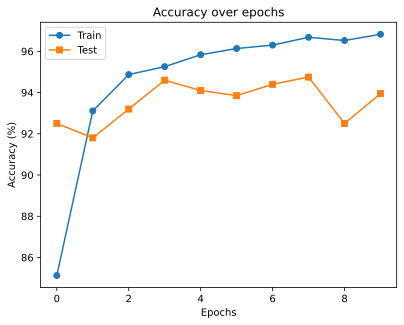

In [ ]:
# Run the model without changing the weights; this will be the baseline performance.
# Notice the model creation is outside the function2train
net_base,lossfun,optimizer = createTheMNISTNet()
trainAcc_base,testAcc_base,losses,net_base = function2trainTheModel(net_base,lossfun,optimizer)

# plot the results
plt.plot(range(len(trainAcc_base)),trainAcc_base,'o-', range(len(testAcc_base)),testAcc_base ,'s-')
plt.legend(['Train','Test'])
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.show()

In [ ]:
# Change the weights before training
net_zero,lossfun,optimizer = createTheMNISTNet()

# set to zeros
net_zero.fc1.weight.data = torch.zeros_like( net_zero.fc1.weight )

# confirm
net_zero.fc1.weight.data

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

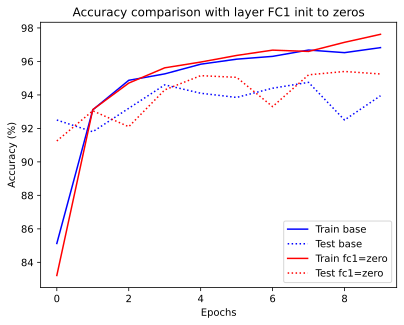

In [ ]:
# run the model and show the results
trainAcc_zero,testAcc_zero,losses,net_zero = function2trainTheModel(net_zero,lossfun,optimizer)

plt.plot(range(len(trainAcc_base)),trainAcc_base,'b-', range(len(testAcc_base)),testAcc_base ,'b:')
plt.plot(range(len(trainAcc_zero)),trainAcc_zero,'r-', range(len(testAcc_zero)),testAcc_zero ,'r:')
plt.legend(['Train base','Test base','Train fc1=zero','Test fc1=zero'])
plt.title('Accuracy comparison with layer FC1 init to zeros')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.show()

tensor([[-0.5058, -0.9123, -0.0074,  ..., -0.2727,  0.0512, -0.0432],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0012, -0.3372, -0.2633,  ...,  0.3826,  0.0512,  0.0743],
        ...,
        [ 0.2971, -0.0632, -0.3028,  ...,  0.2019, -0.0510,  0.0660],
        [-0.6054,  0.8539,  0.0933,  ...,  0.6966,  0.0301,  0.0101],
        [-0.2766, -0.2050,  0.1193,  ..., -0.3219,  0.0511, -0.0140]])


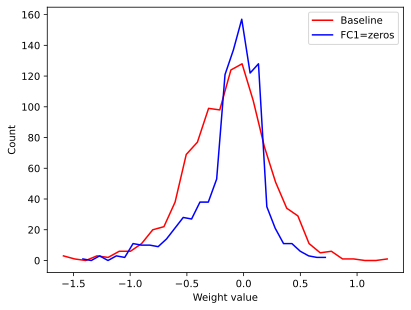

In [ ]:
# Are the weights still zeros?
print(net_zero.fc1.weight.data)

# show the distributions in a histogram
y,x = np.histogram(net_base.fc2.weight.data.flatten(),30)
plt.plot((x[1:]+x[:-1])/2,y,'r',label='Baseline')

y,x = np.histogram(net_zero.fc2.weight.data.flatten(),30)
plt.plot((x[1:]+x[:-1])/2,y,'b',label='FC1=zeros')

plt.legend()
plt.xlabel('Weight value')
plt.ylabel('Count')
plt.show()

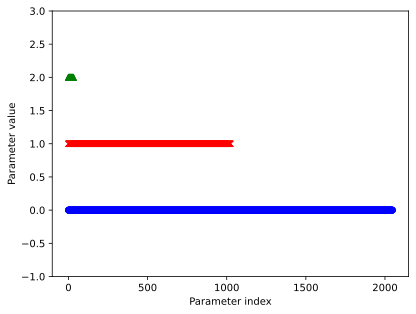

In [ ]:
# Change the weights before training
net_allzero,lossfun,optimizer = createTheMNISTNet()

# loop over parameters and set them all to zeros
for p in net_allzero.named_parameters():
  p[1].data = torch.zeros_like( p[1].data )


# and confirm for a few select parameters (y-axis offset for visibility)
plt.plot(0+net_allzero.fc1.weight.data.flatten(),'bo')
plt.plot(1+net_allzero.fc2.weight.data.flatten(),'rx')
plt.plot(2+net_allzero.fc1.bias.data.flatten(),'g^')
plt.xlabel('Parameter index')
plt.ylim([-1,3])
plt.ylabel('Parameter value')
plt.show()

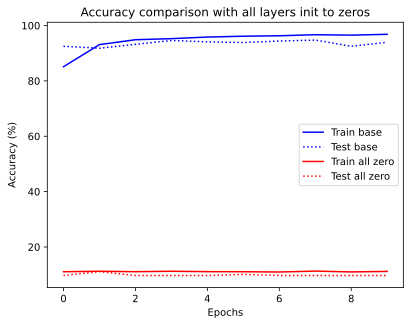

In [ ]:
# run the model and show the results
trainAcc_allzero,testAcc_allzero,losses,net_allzero = function2trainTheModel(net_allzero,lossfun,optimizer)

plt.plot(range(len(trainAcc_base)),trainAcc_base,'b-', range(len(testAcc_base)),testAcc_base ,'b:')
plt.plot(range(len(trainAcc_allzero)),trainAcc_allzero,'r-', range(len(testAcc_allzero)),testAcc_allzero ,'r:')
plt.legend(['Train base','Test base','Train all zero','Test all zero'])
plt.title('Accuracy comparison with all layers init to zeros')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.show()

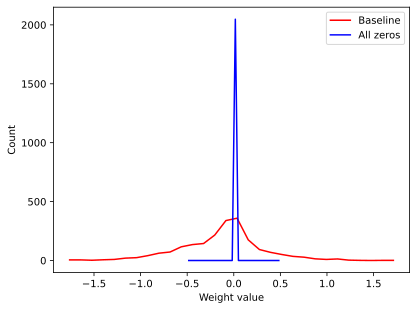

In [ ]:
# show the distributions in a histogram
y,x = np.histogram(net_base.fc1.weight.data.flatten(),30)
plt.plot((x[1:]+x[:-1])/2,y,'r',label='Baseline')

y,x = np.histogram(net_allzero.fc1.weight.data.flatten(),30)
plt.plot((x[1:]+x[:-1])/2,y,'b',label='All zeros')

plt.legend()
plt.xlabel('Weight value')
plt.ylabel('Count')
plt.show()

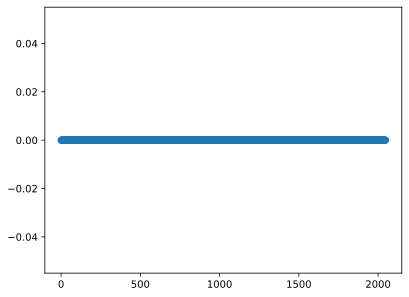

In [ ]:
# woah, not even a single non-zero weight value?!?!!?!!??
plt.plot(net_allzero.fc1.weight.data.flatten(),'o');

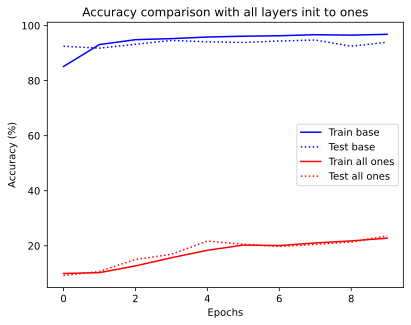

In [ ]:
# Change the weights before training
net_allone,lossfun,optimizer = createTheMNISTNet()
for p in net_allone.named_parameters():
  p[1].data = torch.zeros_like( p[1].data ) + 1
  #p[1].data = torch.zeros( p[1].data.shape ) + 1 # equivalent to the previous line!


# run the model and show the results
trainAcc_allone,testAcc_allone,losses,net_allone = function2trainTheModel(net_allone,lossfun,optimizer)

plt.plot(range(len(trainAcc_base)),trainAcc_base,'b-', range(len(testAcc_base)),testAcc_base ,'b:')
plt.plot(range(len(trainAcc_allone)),trainAcc_allone,'r-', range(len(testAcc_allone)),testAcc_allone ,'r:')
plt.legend(['Train base','Test base','Train all ones','Test all ones'])
plt.title('Accuracy comparison with all layers init to ones')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.show()

Xavier and Kaiming (weights initialisation)

In [ ]:
# create a class for the model
class thenet(nn.Module):
  def __init__(self):
    super().__init__()

    ### input layer
    self.input = nn.Linear(100,100)

    ### hidden layer
    self.fc1 = nn.Linear(100,100)
    self.fc2 = nn.Linear(100,100)
    self.fc3 = nn.Linear(100,100)

    ### output layer
    self.output = nn.Linear(100,2)

  # forward pass
  def forward(self,x):
    x = F.relu( self.input(x) )
    x = F.relu( self.fc1(x) )
    x = F.relu( self.fc2(x) )
    x = F.relu( self.fc3(x) )
    return self.output(x)

In [ ]:
# create an instance of the model
net = thenet()
print(net)

thenet(
  (input): Linear(in_features=100, out_features=100, bias=True)
  (fc1): Linear(in_features=100, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=100, bias=True)
  (output): Linear(in_features=100, out_features=2, bias=True)
)


There are 402 bias parameters.
There are 40200 weight parameters.


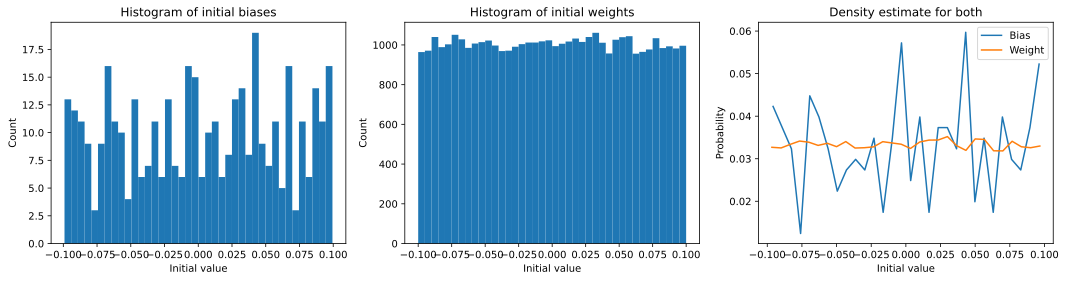

In [ ]:
# collect all weights and biases
allweight = np.array([])
allbiases = np.array([])

for p in net.named_parameters():
  if 'bias' in p[0]:
    allbiases = np.concatenate( (allbiases,p[1].data.numpy().flatten()),axis=0 )
  elif 'weight' in p[0]:
    allweight = np.concatenate( (allweight,p[1].data.numpy().flatten()),axis=0 )


# how many are there?
print(f'There are {len(allbiases)} bias parameters.')
print(f'There are {len(allweight)} weight parameters.')


# show their histograms
fig,ax = plt.subplots(1,3,figsize=(18,4))

ax[0].hist(allbiases,40)
ax[0].set_title('Histogram of initial biases')


ax[1].hist(allweight,40)
ax[1].set_title('Histogram of initial weights')



# collect histogram data to show as line plots
yB,xB = np.histogram(allbiases,30)
yW,xW = np.histogram(allweight,30)

ax[2].plot((xB[1:]+xB[:-1])/2,yB/np.sum(yB),label='Bias')
ax[2].plot((xW[1:]+xW[:-1])/2,yW/np.sum(yW),label='Weight')
ax[2].set_title('Density estimate for both')
ax[2].legend()


# plot adjustments common to all subplots
for i in range(3):
  ax[i].set_xlabel('Initial value')
  ax[i].set_ylabel('Count')
ax[2].set_ylabel('Probability')

plt.show()

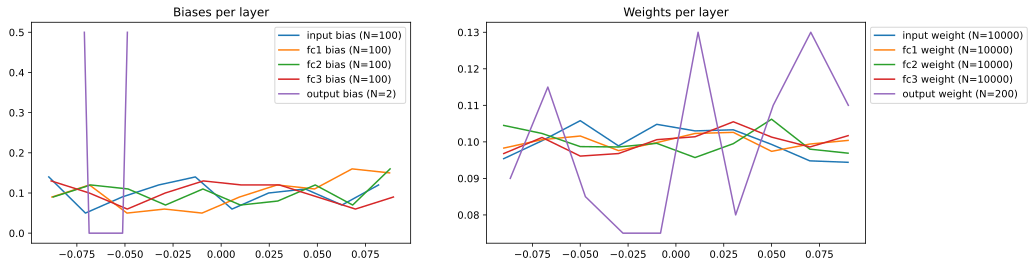

In [ ]:

fig,ax = plt.subplots(1,2,figsize=(15,4))

for p in net.named_parameters():

  # get the data and compute their histogram
  thesedata = p[1].data.numpy().flatten()
  y,x = np.histogram(thesedata,10)

  # for the bias
  if 'bias' in p[0]:
    ax[0].plot((x[1:]+x[:-1])/2,y/np.sum(y),label='%s bias (N=%g)'%(p[0][:-5],len(thesedata)))

  # for the weights
  elif 'weight' in p[0]:
    ax[1].plot((x[1:]+x[:-1])/2,y/np.sum(y),label='%s weight (N=%g)'%(p[0][:-7],len(thesedata)))



ax[0].set_title('Biases per layer')
ax[0].legend()
ax[1].set_title('Weights per layer')
ax[1].legend(bbox_to_anchor=(1,1),loc='upper left')
plt.show()

In [ ]:
# What's up with the weird output bias distribution??
print( net.output.bias.data )

tensor([-0.0475, -0.0723])


In [ ]:
# Check out the docstring for linear layers
nn.Linear?

In [ ]:
# Let's test whether the numbers match our prediction from the formula

# empirical bias range
biasrange = [ torch.min(net.fc1.bias.data).item(), torch.max(net.fc1.bias.data).item() ]
biascount = len(net.fc1.bias.data)

# theoretical expected value
sigma = np.sqrt(1/biascount)

# drum rolllllll.....
print('Theoretical sigma = ' + str(sigma))
print('Empirical range = ' + str(biasrange))

Theoretical sigma = 0.1
Empirical range = [-0.09771038591861725, 0.09730052202939987]


In [ ]:
# create a new instance of the model
net = thenet()

# change the weights (leave biases as Kaiming [default])
for p in net.named_parameters():
  if 'weight' in p[0]:
    nn.init.xavier_normal_(p[1].data)

There are 402 bias parameters.
There are 40200 weight parameters.


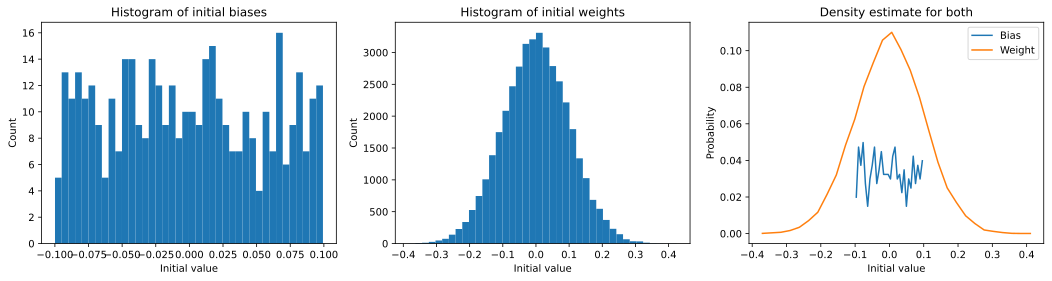

In [ ]:
# collect all weights and biases
allweight = np.array([])
allbiases = np.array([])

for p in net.named_parameters():
  if 'bias' in p[0]:
    allbiases = np.concatenate( (allbiases,p[1].data.numpy().flatten()),axis=0 )
  elif 'weight' in p[0]:
    allweight = np.concatenate( (allweight,p[1].data.numpy().flatten()),axis=0 )


# how many are there?
print(f'There are {len(allbiases)} bias parameters.')
print(f'There are {len(allweight)} weight parameters.')


# show their histograms
fig,ax = plt.subplots(1,3,figsize=(18,4))

ax[0].hist(allbiases,40)
ax[0].set_title('Histogram of initial biases')


ax[1].hist(allweight,40)
ax[1].set_title('Histogram of initial weights')



# collect histogram data to show as line plots
yB,xB = np.histogram(allbiases,30)
yW,xW = np.histogram(allweight,30)

ax[2].plot((xB[1:]+xB[:-1])/2,yB/np.sum(yB),label='Bias')
ax[2].plot((xW[1:]+xW[:-1])/2,yW/np.sum(yW),label='Weight')
ax[2].set_title('Density estimate for both')
ax[2].legend()


# plot adjustments common to all subplots
for i in range(3):
  ax[i].set_xlabel('Initial value')
  ax[i].set_ylabel('Count')
ax[2].set_ylabel('Probability')

plt.show()

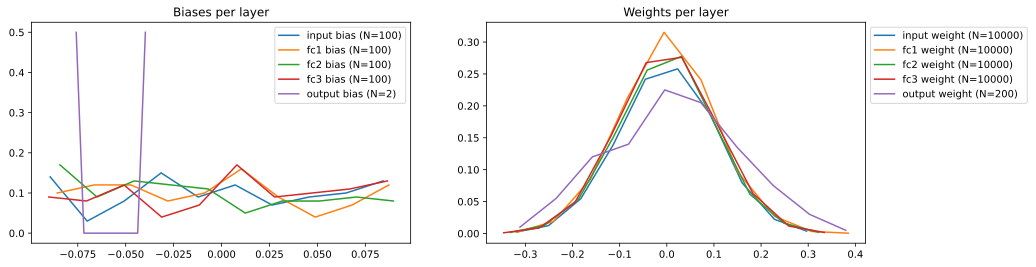

In [ ]:

fig,ax = plt.subplots(1,2,figsize=(15,4))

for p in net.named_parameters():

  # get the data and compute their histogram
  thesedata = p[1].data.numpy().flatten()
  y,x = np.histogram(thesedata,10)

  # for the bias
  if 'bias' in p[0]:
    ax[0].plot((x[1:]+x[:-1])/2,y/np.sum(y),label='%s bias (N=%g)'%(p[0][:-5],len(thesedata)))

  # for the weights
  elif 'weight' in p[0]:
    ax[1].plot((x[1:]+x[:-1])/2,y/np.sum(y),label='%s weight (N=%g)'%(p[0][:-7],len(thesedata)))



ax[0].set_title('Biases per layer')
ax[0].legend()
ax[1].set_title('Weights per layer')
ax[1].legend(bbox_to_anchor=(1,1),loc='upper left')
plt.show()

In [ ]:
# Let's test whether the numbers match our prediction from the formula

# empirical weight standard deviation
weightvar   = torch.var(net.fc1.weight.data.flatten()).item()
weightcount = len(net.fc1.weight.data)

# theoretical expected value
sigma2 = 2 / (weightcount+weightcount)

# drum rolllllll.....
print('Theoretical sigma = ' + str(sigma2))
print('Empirical variance = ' + str(weightvar))

Theoretical sigma = 0.01
Empirical variance = 0.009786231443285942


In [ ]:
# Note: There are several other weights initialization methods availabe in PyTorch.
#       See https://pytorch.org/docs/stable/nn.init.html

Freezing Weights

In [ ]:
# import dataset (comes with colab!)
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# extract labels (number IDs) and remove from data
labels = data[:,0]
data   = data[:,1:]

# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

In [ ]:
# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long()

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)

# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [ ]:
# create a class for the model
def createTheMNISTNet():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)

      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return self.output(x)

  # create the model instance
  net = mnistNet()

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer (using SGD to slow down learning!)
  optimizer = torch.optim.SGD(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [ ]:
# inspect the "learning toggle" of a layer
N = createTheMNISTNet()[0]
N.fc1.weight.requires_grad

True

In [ ]:
N = createTheMNISTNet()[0]

# switch off all layers except input
for p in N.named_parameters():
  if 'input' not in p[0]:
    p[1].requires_grad = False


# check what we've done
for p in N.named_parameters():
  print('Requires_grad status in layer %s: %s' %(p[0],p[1].requires_grad))

Requires_grad status in layer input.weight: True
Requires_grad status in layer input.bias: True
Requires_grad status in layer fc1.weight: False
Requires_grad status in layer fc1.bias: False
Requires_grad status in layer fc2.weight: False
Requires_grad status in layer fc2.bias: False
Requires_grad status in layer output.weight: False
Requires_grad status in layer output.bias: False


In [ ]:
def function2trainTheModel(net,lossfun,optimizer):

  # number of epochs
  numepochs = 100

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):




    # NEW: switch off learning in all-but-output layers during first 1/2 of training
    if epochi<(numepochs/2):
      for p in net.named_parameters():
        if 'output' not in p[0]:
          p[1].requires_grad = False
    else:
      for p in net.named_parameters():
        p[1].requires_grad = True





    # loop over training data batches
    net.train()
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)

    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )
  # end epochs

  # function output
  return trainAcc,testAcc,losses,net

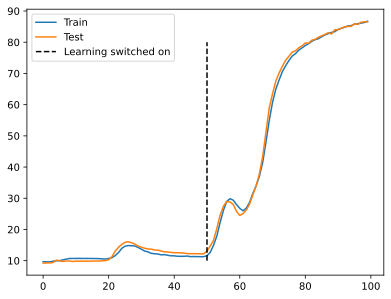

In [ ]:
# create the network
net,lossfun,optimizer = createTheMNISTNet()

# train the model
trainAcc,testAcc,losses,net = function2trainTheModel(net,lossfun,optimizer)

plt.plot(trainAcc,label='Train')
plt.plot(testAcc,label='Test')
plt.plot([len(trainAcc)/2, len(trainAcc)/2],[10,80],'k--',label='Learning switched on')
plt.legend()
plt.show()